In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from lora import adapt_model, LowRankSequential
from data.mnist import load_flat_mnist_datasets
from training.train import train_classifier
from viz.plot import plot_training_curves
from utils.params import count_params, count_trainable_params

In [9]:
def init_mnist_classifier(hidden_size: int = 128) -> nn.Module:
    return nn.Sequential(
    nn.Linear(28 * 28, hidden_size),
    nn.LeakyReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(),
    nn.Linear(hidden_size, 10)
)

torch.Size([784]) tensor(-0.5000) tensor(0.5000)
5


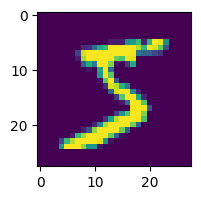

In [10]:
mnist_train, mnist_eval = load_flat_mnist_datasets()

# flatten MNIST into (28 * 28,) vectors and use a dense classifier
sample, targets = mnist_train[0]
print(sample.shape, sample.min(), sample.max())

plt.figure(figsize=(2, 2))
plt.imshow(sample.reshape((28, 28)).numpy())
print(targets)

In [11]:
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
eval_loader = DataLoader(mnist_eval, batch_size=32, shuffle=False)

In [12]:
device = torch.device("mps")

In [19]:
classifier = init_mnist_classifier(hidden_size=1024)
n_params = count_params(classifier)
n_trainable_params = count_trainable_params(classifier)

# format to have comma
print(f"Total params: {n_params:,}, trainable params: {n_trainable_params:,}")

lora_classifier = LowRankSequential.from_sequential(classifier, rank=16).to(device)
lora_n_params = count_params(lora_classifier)
lora_n_trainable_params = count_trainable_params(lora_classifier)
print(f"Total params (LoRA): {lora_n_params:,}, trainable params (LoRA): {lora_n_trainable_params:,}")

lora_model_size = lora_n_params / n_params
lora_trainable_model_size = lora_n_trainable_params / n_trainable_params
print(f"Model size (LoRA): {lora_model_size:.2f}, trainable model size (LoRA): {lora_trainable_model_size:.2f}")

optimizer = optim.Adam(lora_classifier.parameters())
loss_fn = nn.CrossEntropyLoss()

Total params: 1,863,690, trainable params: 1,863,690
Total params (LoRA): 1,941,930, trainable params (LoRA): 80,298
Model size (LoRA): 1.04, trainable model size (LoRA): 0.04


In [ ]:
classifier, train_loss_history, eval_loss_history, eval_acc_history = train_classifier(
    lora_classifier,
    optimizer,
    loss_fn,
    train_loader,
    eval_loader,
    device,
    n_epochs=1
)

In [ ]:
plot_training_curves(
    train_loss_history,
    eval_loss_history,
    eval_acc_history,
    title="MNIST Classifier Training Curves LoRA(rank=16, alpha=1)"
)

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(sample.reshape((28, 28)).numpy())

In [ ]:
class_logits = lora_classifier(sample.to(device).unsqueeze(0))

In [ ]:
class_logits.argmax()

In [ ]:
base_class_logits, lora_class_logits = lora_classifier(sample.to(device).unsqueeze(0), separate_lora_output=True)

In [ ]:
base_class_logits, lora_class_logits

In [ ]:
base_class_logits + lora_class_logits, class_logits